# Phasing haplotypes of gene 1217 in CAMP

Version of the `Phasing-LJA.ipynb` notebook adapted to just analyze "haplotypes" of gene 1217 in CAMP.

The code for performing read smoothing is derived from that notebook's code; ideally we would consolidate these into a single script to limit code reuse, but for the sake of speed I haven't done this yet.

In [6]:
%run "Header.ipynb"
%run "../main-workflow/utils.py"

In [7]:
import os
import time
import pickle
import pysam
import skbio
from collections import defaultdict, Counter
from linked_mutations_utils import find_mutated_positions

## Smooth reads

In [8]:
read2mp2nt = defaultdict(dict)

In [11]:
bf = pysam.AlignmentFile("../main-workflow/output/fully-filtered-and-sorted-aln.bam", "rb")
output_dir = "phasing-data/smoothed-reads/camp_g1217"

# verbose?
no_indoor_voice = False

def write_out_reads(filepath, readname2seq):
    # Notably, this uses the "a" (append) method in order to add to the end of a file
    with open(filepath, "a") as of:
        for readname in readname2seq:
            # Write out both the header and the sequence for each read
            of.write(f">{readname}\n{str(readname2seq[readname])}\n")
            
# both 0-indexed and inclusive
g1217_region = [1208926, 1210074]
focus_region = [g1217_region[0] - 25000, g1217_region[1] + 25000]
            
ALN_UPDATE_FREQ = 5000
ALN_BUFFER_FREQ = 1000

# Set p = 10% when naively identifying mutations to ensure that we just focus on the ~16% mutations
# in gene 1217 of CAMP. Of course, most mutations aren't this common!
P = 10

seq = "edge_6104"

In [12]:
fasta = skbio.DNA.read(f"../seqs/{seq}.fasta")

output_smoothed_reads_file = os.path.join(output_dir, "sr.fasta")

# Identify all (0-indexed, so compatible with skbio / pysam!)
# mutated positions in this genome up front to save time.
#
# Equivalently, we could also just take in an arbitrary VCF as input
# (e.g. one produced from another variant calling tool), although we'd
# need to be careful to only include SNVs and not indels/etc...

print("=" * 70)
print(f"Identifying mutated positions (p = {P}%) in genome {seq2name[seq]}...")
mutpos2pileup = find_mutated_positions(seq, p_to_use=P, incl_pileup=True)
# We sort because the code below relies on these being in ascending order
mutated_positions = sorted(mutpos2pileup.keys())
print(f"Found {len(mutated_positions):,} mutated positions (p = {P}%) in {seq2name[seq]}.")
print(
    f"Note that this tally is higher than you'd see in e.g. the CP1/2/3 plots, because now we're including "
    "both 'rare' and non-rare mutations. Just so you don't waste five minutes sanity-checking this like I did."
)

print("Going through these positions...")

num_ignored_alns = 0

# Instead of just writing out every smoothed alignment as soon as we generate it, we build up a "buffer"
# of these alignments and then write a bunch out at once.
smoothed_aln_buffer = {}

# The first time we see an alignment of a read, it's 1; if we see a supp aln of this read, it's 2; etc.
# Lets us distinguish alignments with different names
readname2freq_so_far = defaultdict(int)

# Go through all linear alignments of each read to this genome, focusing (for now) on just the primary
# alignments...
ts1 = time.time()
for ai, aln in enumerate(bf.fetch(seq), 1):

    if ai % ALN_UPDATE_FREQ == 0:
        print(
            f"\tOn aln {ai:,} in seq {seq2name[seq]}. "
            f"Time spent on {seq2name[seq]} so far: {time.time() - ts1:,.2f} sec."
        )

    if aln.is_secondary:
        raise ValueError(
            "Not to get political or anything, but you should've already filtered secondary alns out"
        )

    # Note that supplementary alignments are ok, though! We implicitly handle these here.
    #
    # Different alignments of the same read will have different new_readnames, because we're gonna
    # be treating them as distinct "reads". We should have already filtered reference-overlapping
    # supp alns so this shouldn't be a problem

    readname = aln.query_name
    readname2freq_so_far[readname] += 1
    new_readname = f"{readname}_{readname2freq_so_far[readname]}"

    # should never happen
    if new_readname in smoothed_aln_buffer:
        raise ValueError("This exact read alignment has already been smoothed? Weird.")

    # Figure out where on the MAG this alignment "hits." These are 0-indexed positions from Pysam.
    # (reference_end points to the position after the actual final position, since these are designed to
    # be interoperable with Python's half-open intervals.)
    #
    # Of course, there likely will be indels within this range: we're purposefully ignoring those here.
    ref_start = aln.reference_start
    ref_end = aln.reference_end - 1

    # This should never happen (TM)
    if ref_start >= ref_end:
        # Du sollst jetzt mit Gott sprechen.
        raise ValueError(
            f"Ref start {ref_start:,} >= ref end {ref_end:,} for read {new_readname}?"
        )

    # Unique to the gene 1217 analysis!
    # Figure out if this read intersects with the focus region.
    # An idiot-proof albeit slow solution is just computing exact ranges and then taking set intersections.
    if not set(range(ref_start, ref_end + 1)) & set(range(focus_region[0], focus_region[1] + 1)):
        continue

    # Smoothed sequence; we'll edit this so that if this read has (mis)matches to any called mutated
    # positions, these positions are updated with the read's aligned nucleotides at these positions.
    smoothed_aln_seq = fasta[ref_start: ref_end + 1]

    # just for debugging: track the exact edits made to smoothed_aln_seq
    replacements_made = {}

    # We may choose to ignore this linear alignment, if we think it is error-prone or
    # otherwise not useful. If this gets set to True in the loop below, then we'll notice this
    # and ignore this alignment.
    ignoring_this_aln = False

    ap = aln.get_aligned_pairs(matches_only=True)

    # Iterating through the aligned pairs is expensive. Since read lengths are generally in the thousands
    # to tens of thousands of bp (which is much less than the > 1 million bp length of any bacterial genome),
    # we set things up so that we only iterate through the aligned pairs once. We maintain an integer, mpi,
    # that is a poor man's "pointer" to an index in mutated_positions.

    mpi = 0

    # Go through this aln's aligned pairs. As we see each pair, compare the pair's reference position
    # (refpos) to the mpi-th mutated position (herein referred to as "mutpos").
    #
    # If refpos >  mutpos, increment mpi until refpos <= mutpos (stopping as early as possible).
    # If refpos == mutpos, we have a match! Update readname2mutpos2ismutated[mutpos] based on
    #                      comparing the read to the reference at the aligned positions.
    # If refpos <  mutpos, continue to the next pair.

    for pair in ap:

        refpos = pair[1]
        mutpos = mutated_positions[mpi]

        no_mutations_to_right_of_here = False

        # Increment mpi until we get to the next mutated position at or after the reference pos for this
        # aligned pair (or until we run out of mutated positions).
        while refpos > mutpos:
            mpi += 1
            if mpi < len(mutated_positions):
                mutpos = mutated_positions[mpi]
            else:
                no_mutations_to_right_of_here = True
                break

        # I expect this should happen only for reads aligned near the right end of the genome.
        if no_mutations_to_right_of_here:
            break

        # If the next mutation occurs after this aligned pair, continue on to a later pair.
        if refpos < mutpos:
            continue

        # If we've made it here, refpos == mutpos!
        # (...unless I messed something up in how I designed this code.)
        if refpos != mutpos:
            raise ValueError("This should never happen!")

        # Finally, get the nucleotide aligned to this mutated position from this read.
        readpos = pair[0]
        read_nt = aln.query_sequence[readpos]

        # If this read doesn't have match the first or second most common nucleotide at this position,
        # ignore this read. In the future, when we perform read
        # smoothing based on an arbitrary set of SNV calls, we can be more careful about this; but for now
        # we make the simplifiying assumption that a mutation likely only has one alternate nucleotide,
        # and that the 3rd and 4th most common nucleotides indicate errors.
        # (Also, note that we break ties here arbitrarily.)
        nt2ct = dict(zip("ACGT", mutpos2pileup[mutpos][0]))
        nt1 = max(nt2ct, key=nt2ct.get)
        del nt2ct[nt1]
        nt2 = max(nt2ct, key=nt2ct.get)

        if read_nt != nt1 and read_nt != nt2:
            if no_indoor_voice:
                print(
                    f"Read {new_readname} has 3rd or 4th most common nt at mutpos {mutpos + 1:,}: "
                    f"pileup = {mutpos2pileup[mutpos]}, read = {read_nt}"
                )
            ignoring_this_aln = True
            break

        # Notably, the nucleotide at a mutated position in a smoothed read will always be the first
        # or second most common nucleotide at this position. So "unreasonable" positions, in which
        # the ref nt != the consensus nt, will not be treated as you might expect -- we ignore the
        # reference in this particular case. Shouldn't make a big difference, since in most cases
        # the ref and consensus nt agree.
        relative_pos_on_aln = mutpos - ref_start
        smoothed_aln_seq = smoothed_aln_seq.replace([relative_pos_on_aln], read_nt)
        replacements_made[relative_pos_on_aln] = read_nt
        read2mp2nt[new_readname][mutpos] = read_nt
        if no_indoor_voice:
            print(
                f"Read {new_readname} mismatches ref at mutpos {mutpos + 1:,}: "
                f"ref = {ref_nt}, read = {read_nt}"
            )

    if no_indoor_voice:
        print(f"Read {new_readname} required {len(replacements_made):,} replacements!")

    if ignoring_this_aln:
        num_ignored_alns += 1
    else:
        # Now that we've finished processing all called mutations that this alignment spans, prepare it
        # to be written out to a FASTA file. See comments above on smoothed_aln_buffer, and why we don't
        # just write everything out as soon as it's ready.
        #
        # (Also, we've already guaranteed readname isn't already in smoothed_aln_buffer, so no need to worry
        # about accidentally overwriting something from earlier.)
        smoothed_aln_buffer[new_readname] = smoothed_aln_seq

        if ai % ALN_BUFFER_FREQ == 0:
            write_out_reads(output_smoothed_reads_file, smoothed_aln_buffer)
            # Clear the buffer
            smoothed_aln_buffer = {}

# We're probably going to have left over smoothed reads that we still haven't written out, unless things
# worked out so that on the final alignment we saw ai was exactly divisible by ALN_BUFFER_FREQ (and that's
# pretty unlikely unless you set the buffer freq to a low number). So make one last dump of the buffer.
if len(smoothed_aln_buffer) > 0:
    write_out_reads(output_smoothed_reads_file, smoothed_aln_buffer)

print(f"We ignored {num_ignored_alns:,} linear alignments, fyi.")
print(f"Done with {seq}! Took {time.time() - ts1:,.2f} sec.")

Identifying mutated positions (p = 10%) in genome CAMP...
Found 35 mutated positions (p = 10%) in CAMP.
Note that this tally is higher than you'd see in e.g. the CP1/2/3 plots, because now we're including both 'rare' and non-rare mutations. Just so you don't waste five minutes sanity-checking this like I did.
Going through these positions...
	On aln 5,000 in seq CAMP. Time spent on CAMP so far: 5.94 sec.
	On aln 10,000 in seq CAMP. Time spent on CAMP so far: 12.91 sec.
	On aln 15,000 in seq CAMP. Time spent on CAMP so far: 20.00 sec.
	On aln 20,000 in seq CAMP. Time spent on CAMP so far: 27.38 sec.
	On aln 25,000 in seq CAMP. Time spent on CAMP so far: 34.27 sec.
	On aln 30,000 in seq CAMP. Time spent on CAMP so far: 40.93 sec.
	On aln 35,000 in seq CAMP. Time spent on CAMP so far: 47.40 sec.
	On aln 40,000 in seq CAMP. Time spent on CAMP so far: 53.94 sec.
	On aln 45,000 in seq CAMP. Time spent on CAMP so far: 60.52 sec.
	On aln 50,000 in seq CAMP. Time spent on CAMP so far: 66.96 sec

In [13]:
with open("phasing-data/smoothed-reads/camp_g1217/read2mp2nt.pickle", "wb") as pf:
    pickle.dump(read2mp2nt, pf)

In [14]:
with open("phasing-data/smoothed-reads/camp_g1217/read2mp2nt.pickle", "rb") as pf:
    read2mp2nt = pickle.load(pf)

## Analyze "haplotypes" of gene 1217

In [15]:
mp2freq = defaultdict(Counter)
for read in read2mp2nt:
    for mp in read2mp2nt[read]:
        mp2freq[mp][read2mp2nt[read][mp]] += 1      

In [16]:
mp2freq

defaultdict(collections.Counter,
            {1209000: Counter({'A': 3757, 'G': 709}),
             1209009: Counter({'A': 3742, 'C': 701}),
             1209021: Counter({'A': 3756, 'G': 709}),
             1209057: Counter({'C': 3771, 'T': 715}),
             1209103: Counter({'C': 3775, 'T': 710}),
             1209114: Counter({'C': 3770, 'A': 703}),
             1209120: Counter({'G': 3774, 'A': 710}),
             1209125: Counter({'A': 3774, 'G': 708}),
             1209132: Counter({'G': 3773, 'A': 704}),
             1209135: Counter({'T': 3769, 'C': 709}),
             1209141: Counter({'G': 3772, 'A': 709}),
             1209144: Counter({'C': 3771, 'T': 707}),
             1209147: Counter({'A': 3772, 'T': 706}),
             1209153: Counter({'T': 3772, 'A': 706}),
             1209204: Counter({'G': 3772, 'A': 708}),
             1209240: Counter({'G': 3781, 'A': 717}),
             1209264: Counter({'T': 3784, 'C': 712}),
             1209265: Counter({'C': 3786, 'G': 71

In [17]:
haps = []
mps = [1209000, 1209009, 1209021, 1209057, 1209103, 1209114, 1209120, 1209125,
       1209132, 1209135, 1209141, 1209144, 1209147, 1209153, 1209204, 1209240,
       1209264, 1209265, 1209296, 1209321, 1209324, 1209336, 1209399, 1209402,
       1209417, 1209420, 1209423, 1209522, 1209576, 1209609, 1209696, 1209699,
       1209756, 1209795]
assert len(mps) == 34
for read in read2mp2nt:
    # if this read spans all of g1217
    if len(read2mp2nt[read]) == 34:
        haps.append("".join([read2mp2nt[read][mp] for mp in mps]))

In [18]:
len(haps)

4054

In [19]:
ctr = Counter(haps)
ctr

Counter({'AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA': 3430,
         'GCGTTAAGACATTAAACGCTTCCGGTCGGTACGG': 600,
         'GAGCTAAGACATTAAACGCTTCCGGTCGGTACGG': 1,
         'GCGTTAAGACATTAAACGCTTCCGATCGGTACGG': 1,
         'GAGTTAAGACATTAAACGCTTCCGGTCGGTACGG': 6,
         'ACGTTAAGACATTAAACGCTTCCGGTCGGTACGG': 2,
         'GCGTTAAGACACTAAACGCTTCCGGTCGGTACGG': 1,
         'GCGTTAAGACATTAAACGCTTCCAGTCGGTACGG': 1,
         'GCATTAAGACATTAAACGCTTCCGGTCGGTACGG': 1,
         'GCGTTAAGACATTAAACGCTTCCGGTCGGTACAG': 4,
         'GCGTTAAGACATTTAACGCTTCCGGTCGGTACGG': 1,
         'GCGTTAAGACATTAAACGCTTCCGGTCGATACGG': 1,
         'GCGTTAAGACATTAGACGCTTCCGGTCGGTACAG': 1,
         'GCGTTAAGACATTAAACGCTTCCGGTCGGTACGA': 2,
         'AAACCCGAGTGCATGGTCTCCTTAACTAGCTTAA': 1,
         'AAACCCGAGTGCATGATCTCCTTAACTAACTTAA': 1})

In [20]:
len(ctr)

16

In [21]:
ref = ctr.most_common(1)[0][0]
assert len(ref) == 34
assert ctr[ref] == 3430
ref

'AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA'

In [22]:
alt = "GCGTTAAGACATTAAACGCTTCCGGTCGGTACGG"
assert ctr[alt] == 600

In [23]:
haplotype_hamrefs = []
haplotype_diffpos = []
for h in ctr:
    rd = []
    ad = []
    for hi, hc in enumerate(h):
        if hc != ref[hi]:
            rd.append(hi + 1)
        if hc != alt[hi]:
            ad.append(hi + 1)
    print(f"{h}: {ctr[h]:,}x, Hamming ref = {len(rd):,}, Hamming alt = {len(ad):,},", end=" ")
    if len(rd) < len(ad):
        print(f"Ref diffs: {rd}")
        haplotype_diffpos += rd
    else:
        print(f"Alt diffs: {ad}")
        haplotype_diffpos += ad
        
    haplotype_hamrefs.append(len(rd))

AAACCCGAGTGCATGGTCTCCTTAACTAACTTAA: 3,430x, Hamming ref = 0, Hamming alt = 34, Ref diffs: []
GCGTTAAGACATTAAACGCTTCCGGTCGGTACGG: 600x, Hamming ref = 34, Hamming alt = 0, Alt diffs: []
GAGCTAAGACATTAAACGCTTCCGGTCGGTACGG: 1x, Hamming ref = 32, Hamming alt = 2, Alt diffs: [2, 4]
GCGTTAAGACATTAAACGCTTCCGATCGGTACGG: 1x, Hamming ref = 33, Hamming alt = 1, Alt diffs: [25]
GAGTTAAGACATTAAACGCTTCCGGTCGGTACGG: 6x, Hamming ref = 33, Hamming alt = 1, Alt diffs: [2]
ACGTTAAGACATTAAACGCTTCCGGTCGGTACGG: 2x, Hamming ref = 33, Hamming alt = 1, Alt diffs: [1]
GCGTTAAGACACTAAACGCTTCCGGTCGGTACGG: 1x, Hamming ref = 33, Hamming alt = 1, Alt diffs: [12]
GCGTTAAGACATTAAACGCTTCCAGTCGGTACGG: 1x, Hamming ref = 33, Hamming alt = 1, Alt diffs: [24]
GCATTAAGACATTAAACGCTTCCGGTCGGTACGG: 1x, Hamming ref = 33, Hamming alt = 1, Alt diffs: [3]
GCGTTAAGACATTAAACGCTTCCGGTCGGTACAG: 4x, Hamming ref = 33, Hamming alt = 1, Alt diffs: [33]
GCGTTAAGACATTTAACGCTTCCGGTCGGTACGG: 1x, Hamming ref = 33, Hamming alt = 1, Alt diffs: [14

Text(0.5, 1.0, 'Positional variation across\nthe 26 non-primary haplotypes')

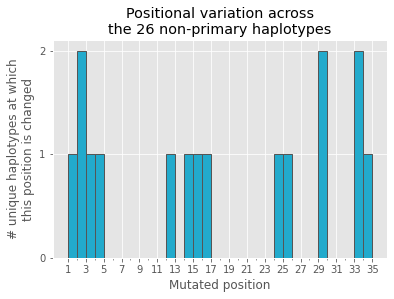

In [24]:
fig, ax = pyplot.subplots()
ax.hist(haplotype_diffpos, bins=range(1,36,1), color="#22aacc", lw=1, edgecolor="#555555")
ax.set_xticks(range(1, 36, 2))
ax.set_xticks(range(1, 36), minor=True)
ax.set_yticks([0, 1, 2])
ax.set_xlabel("Mutated position")
ax.set_ylabel("# unique haplotypes at which\nthis position is changed")
ax.set_title("Positional variation across\nthe 26 non-primary haplotypes")

Text(0.5, 1.0, 'Histogram of haplotype coverages in CAMP gene 1217,\nignoring the primary haplotypes (3,430x and 600x)')

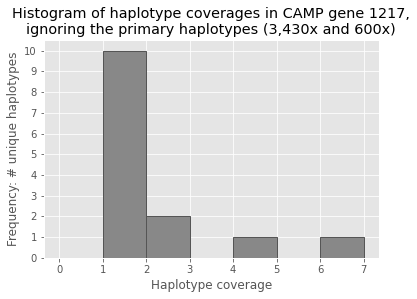

In [25]:
haplotype_covs = [ctr[h] for h in ctr]
fig, ax = pyplot.subplots()
ax.hist(haplotype_covs, bins=range(0,8,1), color="#888888", lw=1, edgecolor="#555555")
ax.set_yticks(range(0, 11, 1))
ax.set_xlabel('Haplotype coverage')
ax.set_ylabel("Frequency: # unique haplotypes")
ax.set_title("Histogram of haplotype coverages in CAMP gene 1217,\nignoring the primary haplotypes (3,430x and 600x)")

Text(0.5, 1.0, 'Histogram of haplotype Hamming distances\nin CAMP gene 1217')

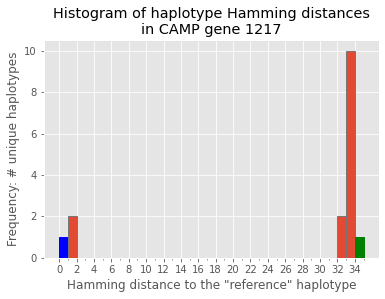

In [26]:
fig, ax = pyplot.subplots()
ax.hist(haplotype_hamrefs, bins=range(0,36,1), lw=1, edgecolor="#777777")
ax.set_xticks(range(0, 36, 2))
ax.set_xticks(range(0, 36), minor=True)
ax.set_xlabel('Hamming distance to the "reference" haplotype')
ax.set_ylabel("Frequency: # unique haplotypes")
# color bars representing the ref and alt haplotype specially:
# https://stackoverflow.com/a/18973430
children = ax.get_children()
children[0].set_color("blue")
children[-11].set_color("green")
ax.set_title("Histogram of haplotype Hamming distances\nin CAMP gene 1217")

## Assemble smoothed reads (multiple methods)

This'll let us see which haplotype(s) show up in these assemblies!

### metaFlye (default, and with `--keep-haplotypes`)

In [ ]:
%%bash
flye --pacbio-hifi phasing-data/smoothed-reads/camp_g1217/sr.fasta \
    --meta \
    --out-dir phasing-data/smoothed-reads/camp_g1217/metaflye

In [ ]:
%%bash
flye --pacbio-hifi phasing-data/smoothed-reads/camp_g1217/sr.fasta \
    --meta \
    --keep-haplotypes \
    --out-dir phasing-data/smoothed-reads/camp_g1217/metaflye_keephaps

### Just jumboDBG ($k$ = 5,001)

In [ ]:
%%bash
/home/mfedarko/software/LJA/bin/jumboDBG \
    --reads phasing-data/smoothed-reads/camp_g1217/sr.fasta \
    -k 5001 \
    --coverage \
    --output-dir phasing-data/smoothed-reads/camp_g1217/jumbodbg_k5001

### LJA (with error correction; with no error correction; with a simple coverage filter)

In [ ]:
%%bash
# Default: with error correction
/home/mfedarko/software/LJA-branch/bin/lja \
    --reads phasing-data/smoothed-reads/camp_g1217/sr.fasta \
    --output-dir phasing-data/smoothed-reads/camp_g1217/lja_withec

In [ ]:
%%bash
# No error correction
/home/mfedarko/software/LJA-branch/bin/lja \
    --reads phasing-data/smoothed-reads/camp_g1217/sr.fasta \
    --noec \
    --output-dir phasing-data/smoothed-reads/camp_g1217/lja_noec

In [ ]:
%%bash
# No error correction, but with a filter for low-coverage edges. (Let's say 10x; at least for G1217, we know
# this removes the relatively low-coverage haplotypes. Of course, for arbitrary data the optimal parameter here
# isn't clear. But when you have like ~4,000x coverage 10x is fine.)
/home/mfedarko/software/LJA-branch/bin/lja \
    --reads phasing-data/smoothed-reads/camp_g1217/sr.fasta \
    --simpleec \
    --Cov-threshold 10 \
    --output-dir phasing-data/smoothed-reads/camp_g1217/lja_covfilt_10x

## Align assembled sequences to CAMP

In [ ]:
%%bash
CAMP=/Poppy/mfedarko/sheepgut/seqs/edge_6104.fasta
OUTDIR=phasing-data/smoothed-reads/camp_g1217/aln

# Yeah this could be done in a simple for loop but bash scares me

# metaFlye
minimap2 -ax asm20 --MD $CAMP \
    phasing-data/smoothed-reads/camp_g1217/metaflye/assembly.fasta > $OUTDIR/metaflye.sam
minimap2 -ax asm20 --MD $CAMP \
    phasing-data/smoothed-reads/camp_g1217/metaflye_keephaps/assembly.fasta > $OUTDIR/metaflye_keephaps.sam
    
# jumboDBG
minimap2 -ax asm20 --MD $CAMP \
    phasing-data/smoothed-reads/camp_g1217/jumbodbg_k5001/graph.fasta > $OUTDIR/jumbodbg.sam
    
# LJA
minimap2 -ax asm20 --MD $CAMP \
    phasing-data/smoothed-reads/camp_g1217/lja_withec/assembly.fasta > $OUTDIR/lja_withec.sam
minimap2 -ax asm20 --MD $CAMP \
    phasing-data/smoothed-reads/camp_g1217/lja_noec/assembly.fasta > $OUTDIR/lja_noec.sam
minimap2 -ax asm20 --MD $CAMP \
    phasing-data/smoothed-reads/camp_g1217/lja_covfilt_10x/assembly.fasta > $OUTDIR/lja_covfilt_10x.sam

## Investigate alignments of assembled sequences to CAMP

Which haplotypes of gene 1217 were recovered?

In [ ]:
aln_dir = "phasing-data/smoothed-reads/camp_g1217/aln"
for af in os.listdir(aln_dir):
    if af.endswith(".sam"):
        print(f"Investigating the alignment described in {af}.")
        f = pysam.AlignmentFile(os.path.join(aln_dir, af))
        contig2hap = {}
        contig_haps = []
        num_nonspanning_contigs = 0
        for aln in f.fetch():
            ap = aln.get_aligned_pairs(matches_only=True)
            aln_seq = aln.query_sequence
            contig_name = aln.query_name
            v = {}
            hap = ""
            # slow but simple
            for pair in ap:
                if pair[1] in mps:
                    contig_nt_at_mutpos = aln_seq[pair[0]]
                    v[pair[1]] = contig_nt_at_mutpos
                    hap += contig_nt_at_mutpos
            if len(v) < 34:
                num_nonspanning_contigs += 1
            elif len(v) > 34:
                raise ValueError("Something went very wrong. What happened to gene 1217???")
            else:
                contig2hap[contig_name] = hap
                contig_haps.append(hap)
                print(f"\t{hap}  Smoothed Read Freq: {ctr[hap]:,}x  Contig {contig_name}") 

        print(f"\t# of contig haps: {len(contig_haps):,}\n\t# of unique contig haps: {len(set(contig_haps)):,}")